# Lab 8: NeRF and Gaussian Splatting

Welcome to COMSM0159 Advanced Visual AI (AVAI)!

  This lab aims to introduce NeRF (Neural Radiance Fields) and Gaussian Splatting, building on concepts from the Week 8 lecture. By the end of the lab, you should be able to:

  - Implement a basic NeRF model.
  - Implement a simple Gaussian Splatting technique.
  - Compare NeRF and Gaussian Splatting in terms of rendering quality, speed, and memory usage.

  ### Tasks:

  1. **NeRF Implementation:**

    - Use an existing NeRF implementation or framework (e.g., PyTorch NeRF).
    - Train the model on a small dataset of 2D images to synthesize novel views of a 3D scene.
    - Experiment with rendering new views from different camera angles.

  2. **Gaussian Splatting:**

    - Implement a simple Gaussian Splatting technique to render a 3D scene using a set of 3D Gaussian functions.
    - Use point cloud data to initialize the 3D Gaussians.
    - Project the Gaussians onto the image plane to render the scene.

  3. **Comparison of Results:**

    - Compare the rendering quality, speed, and memory usage of NeRF and Gaussian Splatting.
    - Evaluate the trade-offs in terms of photorealism vs. rendering speed.

## Part1 NeRF
This lab is built on https://colab.research.google.com/drive/1TppdSsLz8uKoNwqJqDGg8se8BHQcvg_K?usp=sharing and https://github.com/bmild/nerf/tree/master

## Imports

In [ ]:
import os
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange

# For repeatability
# seed = 3407
# torch.manual_seed(seed)
# np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preparation

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2024-10-24 15:05:22--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-10-24 15:05:22--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  --.-KB/s    in 0.1s    

2024-10-24 15:05:22 (109 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



Load Input Images and Poses

Task1.1

Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal length: 138.88887889922103
Pose
[[ 6.8935126e-01  5.3373039e-01 -4.8982298e-01 -1.9745398e+00]
 [-7.2442728e-01  5.0788772e-01 -4.6610624e-01 -1.8789345e+00]
 [ 1.4901163e-08  6.7615211e-01  7.3676193e-01  2.9699826e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


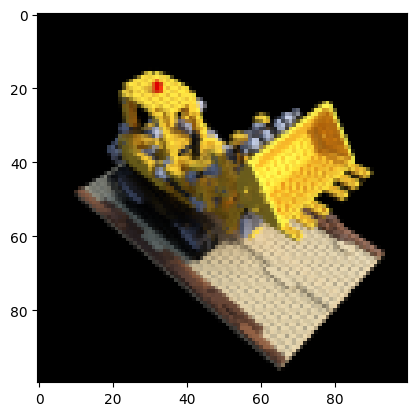

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']


H, W = images.shape[1:3]

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

# TODO: print the shape of Images, poses and focal

# TODO: display the testimg and its pose

## Optimize NeRF

In [ ]:
def get_rays(
  height: int,
  width: int,
  focal_length: float,
  c2w: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
  r"""
  Find origin and direction of rays through every pixel and camera origin.

  height: int
  Represents the height (number of pixels) of the image. Used to construct a grid to cover the vertical dimension of each pixel (i.e. the y-axis direction of the image).

  width: int
  Represents the width of the image (number of pixels). Used to construct the grid to cover the horizontal dimension of each pixel (i.e. the x-direction of the image).

  focal_length: float
  The focal length of the camera, used to convert pixel coordinates to ray directions in world coordinates.
  According to the pinhole camera model, the focal length determines the offset between the ray and the camera's optical axis.

  c2w: torch.
  Transformation matrix from the camera to the world coordinate system of shape (4, 4).
  This matrix is used to transform the rays from the camera coordinate system to the world coordinate system.
  c2w[:3, :3] is the rotation matrix part, which is used to rotate the ray direction, and c2w[:3, -1] is the position (optical center) of the camera, which is used to determine the starting point of all rays.

  rays_o: torch.Tensor
  The starting point of each ray, all rays are located at the center of the camera's optical center, i.e. the camera's position. The shape is (height, width, 3).

  rays_d: torch.Tensor
  The ray direction corresponding to each pixel, representing the vector of ray directions from the center of the camera's light through the pixel. The shape is (height, width, 3).

  """

  # Apply pinhole camera model to gather directions at each pixel
  i, j = torch.meshgrid(
      torch.arange(width, dtype=torch.float32).to(c2w),
      torch.arange(height, dtype=torch.float32).to(c2w),
      indexing='ij')
  i, j = i.transpose(-1, -2), j.transpose(-1, -2)
  directions = torch.stack([(i - width * .5) / focal_length,
                            -(j - height * .5) / focal_length,
                            -torch.ones_like(i)
                           ], dim=-1)

  # Apply camera pose to directions
  rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)

  # Origin is same for all directions (the optical center)
  rays_o = c2w[:3, -1].expand(rays_d.shape)
  return rays_o, rays_d

Taks1.2

dirs
(100, 3)
[ 0.01334572 -0.95394367 -0.29968831]

origins
(100, 3)
[-0.05379832  3.8454704   1.2080823 ]



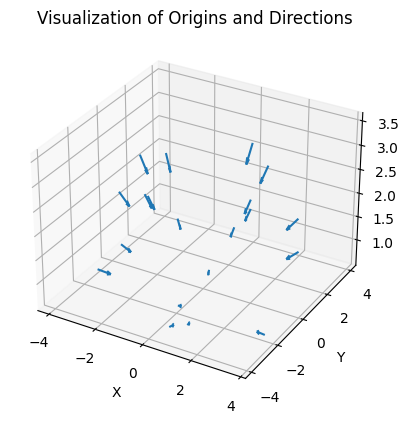

In [ ]:
# Drawing arrows that depict the origin and the direction of every frame.
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
origins = poses[:, :3, -1]

print('dirs')
print(dirs.shape)
print(dirs[0, :])
print('')

print('origins')
print(origins.shape)
print(origins[0, :])
print('')
num_rays_to_visualize = 100
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0, num_rays_to_visualize, 5):
  # TODO:


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
plt.title('Visualization of Origins and Directions')
plt.show()

Task1.3

Ray Origin
torch.Size([100, 100, 3])
tensor([-0.0538,  3.8455,  1.2081])

Ray Direction
torch.Size([100, 100, 3])
tensor([ 0.0133, -0.9539, -0.2997])



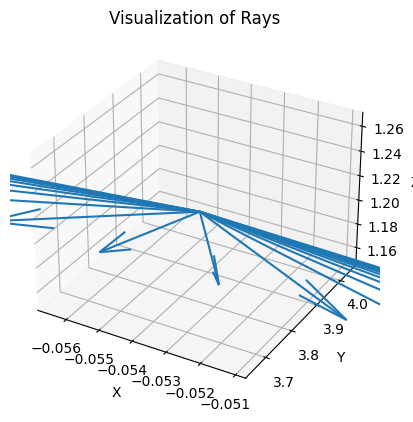

In [ ]:
# Write a script to show how get_rays() works and visualize it

# TODO: Pass parameters to the function get_rays() to get rays_o, rays_d
rays_o, rays_d = get_rays()



print('Ray Origin')
print(rays_o.shape)
print(rays_o[H // 2, W // 2, :])
print('')

print('Ray Direction')
print(rays_d.shape)
print(rays_d[H // 2, W // 2, :])
print('')

# Visualize a subset of rays
num_rays_to_visualize = 100
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0, num_rays_to_visualize, 5):
  ray_origin = rays_o[i, i].cpu().numpy()
  ray_direction = rays_d[i, i].cpu().numpy()
  ax.quiver(ray_origin[0], ray_origin[1], ray_origin[2],
            ray_direction[0], ray_direction[1], ray_direction[2],
            length=0.1, normalize=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Visualization of Rays')
plt.show()

In [ ]:
def sample_stratified(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  near: float,
  far: float,
  n_samples: int,
  perturb: Optional[bool] = True,
  inverse_depth: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
  r"""
  Sample along ray from regularly-spaced bins.
  """

  # Grab samples for space integration along ray
  t_vals = torch.linspace(0., 1., n_samples, device=rays_o.device)
  if not inverse_depth:
    # Sample linearly between `near` and `far`
    z_vals = near * (1.-t_vals) + far * (t_vals)
  else:
    # Sample linearly in inverse depth (disparity)
    z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

  # Draw uniform samples from bins along ray
  if perturb:
    mids = .5 * (z_vals[1:] + z_vals[:-1])
    upper = torch.concat([mids, z_vals[-1:]], dim=-1)
    lower = torch.concat([z_vals[:1], mids], dim=-1)
    t_rand = torch.rand([n_samples], device=z_vals.device)
    z_vals = lower + (upper - lower) * t_rand
  z_vals = z_vals.expand(list(rays_o.shape[:-1]) + [n_samples])

  # Apply scale from `rays_d` and offset from `rays_o` to samples
  # pts: (width, height, n_samples, 3)
  pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
  return pts, z_vals

In [ ]:
# Draw stratified samples from example

images = data['images']
poses = data['poses']
focal = data['focal']

H, W = images.shape[1:3]

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

images = torch.from_numpy(images).to(device)
poses = torch.from_numpy(poses).to(device)
focal = torch.from_numpy(focal).to(device)
testimg = torch.from_numpy(testimg).to(device)
testpose = torch.from_numpy(testpose).to(device)

with torch.no_grad():
  ray_origin, ray_direction = get_rays(H, W, focal, testpose)

rays_o = ray_origin.view([-1, 3])
rays_d = ray_direction.view([-1, 3])
near, far = 2., 6.
n_samples = 8
perturb = True
inverse_depth = False

with torch.no_grad():
  pts, z_vals = sample_stratified(rays_o, rays_d, near, far, n_samples, perturb=perturb, inverse_depth=inverse_depth)

print('Input Points')
print(pts.shape)
print('')
print('Distances Along Ray')
print(z_vals.shape)

Input Points
torch.Size([10000, 8, 3])

Distances Along Ray
torch.Size([10000, 8])


Task1.4

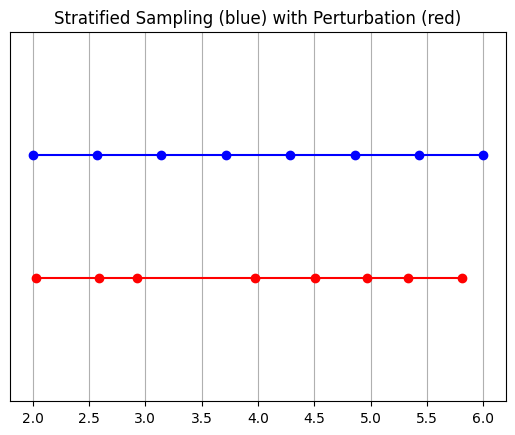

In [ ]:
# Visualize the sampled unperturbed and perturbed points.
with torch.no_grad():
  # TODO: Pass parameters to the function sample_stratified() to get the sampled unperturbed and perturbed points.
  # pts, z_vals = sample_stratified()
  # _, z_vals_unperturbed = sample_stratified()

y_vals = torch.zeros_like(z_vals)

fig = plt.figure()
plt.plot(z_vals_unperturbed[0].cpu().numpy(), 1 + y_vals[0].cpu().numpy(), 'b-o')
plt.plot(z_vals[0].cpu().numpy(), y_vals[0].cpu().numpy(), 'r-o')
plt.ylim([-1, 2])
plt.title('Stratified Sampling (blue) with Perturbation (red)')
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.grid(True)

In [ ]:
class PositionalEncoder(nn.Module):
  r"""
  Sine-cosine positional encoder for input points.
  """
  def __init__(
    self,
    d_input: int,
    n_freqs: int,
    log_space: bool = False
  ):
    super().__init__()
    self.d_input = d_input
    self.n_freqs = n_freqs
    self.log_space = log_space
    self.d_output = d_input * (1 + 2 * self.n_freqs)
    self.embed_fns = [lambda x: x]

    # Define frequencies in either linear or log scale
    if self.log_space:
      freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
    else:
      freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

    # Alternate sin and cos
    for freq in freq_bands:
      self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
      self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

  def forward(
    self,
    x
  ) -> torch.Tensor:
    r"""
    Apply positional encoding to input.
    """
    return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)

In [ ]:
# Create encoders for points and view directions
encoder = PositionalEncoder(3, 10)
viewdirs_encoder = PositionalEncoder(3, 4)

# Grab flattened points and view directions
pts_flattened = pts.reshape(-1, 3)
viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
flattened_viewdirs = viewdirs[:, None, ...].expand(pts.shape).reshape((-1, 3))

# Encode inputs
encoded_points = encoder(pts_flattened)
encoded_viewdirs = viewdirs_encoder(flattened_viewdirs)

print('Encoded Points')
print(encoded_points.shape)
print(torch.min(encoded_points), torch.max(encoded_points), torch.mean(encoded_points))
print('')

print(encoded_viewdirs.shape)
print('Encoded Viewdirs')
print(torch.min(encoded_viewdirs), torch.max(encoded_viewdirs), torch.mean(encoded_viewdirs))
print('')

Encoded Points
torch.Size([80000, 63])
tensor(-2.6926, device='cuda:0') tensor(3.4030, device='cuda:0') tensor(0.0277, device='cuda:0')

torch.Size([80000, 27])
Encoded Viewdirs
tensor(-1., device='cuda:0') tensor(1., device='cuda:0') tensor(0.1056, device='cuda:0')



## Define the NeRF Model

In [ ]:
class NeRF(nn.Module):
  r"""
  Neural radiance fields module.
  """
  def __init__(
    self,
    d_input: int = 3,
    n_layers: int = 8,
    d_filter: int = 256,
    skip: Tuple[int] = (4,),
    d_viewdirs: Optional[int] = None
  ):
    super().__init__()
    self.d_input = d_input
    self.skip = skip
    self.act = nn.functional.relu
    self.d_viewdirs = d_viewdirs

    # Create model layers
    self.layers = nn.ModuleList(
      [nn.Linear(self.d_input, d_filter)] +
      [nn.Linear(d_filter + self.d_input, d_filter) if i in skip \
       else nn.Linear(d_filter, d_filter) for i in range(n_layers - 1)]
    )

    # Bottleneck layers
    if self.d_viewdirs is not None:
      # If using viewdirs, split alpha and RGB
      self.alpha_out = nn.Linear(d_filter, 1)
      self.rgb_filters = nn.Linear(d_filter, d_filter)
      self.branch = nn.Linear(d_filter + self.d_viewdirs, d_filter // 2)
      self.output = nn.Linear(d_filter // 2, 3)
    else:
      # If no viewdirs, use simpler output
      self.output = nn.Linear(d_filter, 4)

  def forward(
    self,
    x: torch.Tensor,
    viewdirs: Optional[torch.Tensor] = None
  ) -> torch.Tensor:
    r"""
    Forward pass with optional view direction.
    """

    # Cannot use viewdirs if instantiated with d_viewdirs = None
    if self.d_viewdirs is None and viewdirs is not None:
      raise ValueError('Cannot input x_direction if d_viewdirs was not given.')

    # Apply forward pass up to bottleneck
    x_input = x
    for i, layer in enumerate(self.layers):
      x = self.act(layer(x))
      if i in self.skip:
        x = torch.cat([x, x_input], dim=-1)

    # Apply bottleneck
    if self.d_viewdirs is not None:
      # Split alpha from network output
      alpha = self.alpha_out(x)

      # Pass through bottleneck to get RGB
      x = self.rgb_filters(x)
      x = torch.concat([x, viewdirs], dim=-1)
      x = self.act(self.branch(x))
      x = self.output(x)

      # Concatenate alphas to output
      x = torch.concat([x, alpha], dim=-1)
    else:
      # Simple output
      x = self.output(x)
    return x


# Volume Rendering
def cumprod_exclusive(
  tensor: torch.Tensor
) -> torch.Tensor:
  r"""
  (Courtesy of https://github.com/krrish94/nerf-pytorch)

  Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
  tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
    is to be computed.
  Returns:
  cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
    tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """

  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, -1)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, -1)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

def raw2outputs(
  raw: torch.Tensor,
  z_vals: torch.Tensor,
  rays_d: torch.Tensor,
  raw_noise_std: float = 0.0,
  white_bkgd: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
  r"""
  Convert the raw NeRF output into RGB and other maps.
  """

  # Difference between consecutive elements of `z_vals`. [n_rays, n_samples]
  dists = z_vals[..., 1:] - z_vals[..., :-1]
  dists = torch.cat([dists, 1e10 * torch.ones_like(dists[..., :1])], dim=-1)

  # Multiply each distance by the norm of its corresponding direction ray
  # to convert to real world distance (accounts for non-unit directions).
  dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

  # Add noise to model's predictions for density. Can be used to
  # regularize network during training (prevents floater artifacts).
  noise = 0.
  if raw_noise_std > 0.:
    noise = torch.randn(raw[..., 3].shape) * raw_noise_std

  # Predict density of each sample along each ray. Higher values imply
  # higher likelihood of being absorbed at this point. [n_rays, n_samples]
  alpha = 1.0 - torch.exp(-nn.functional.relu(raw[..., 3] + noise) * dists)

  # Compute weight for RGB of each sample along each ray. [n_rays, n_samples]
  # The higher the alpha, the lower subsequent weights are driven.
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  # Compute weighted RGB map.
  rgb = torch.sigmoid(raw[..., :3])  # [n_rays, n_samples, 3]
  rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # [n_rays, 3]

  # Estimated depth map is predicted distance.
  depth_map = torch.sum(weights * z_vals, dim=-1)

  # Disparity map is inverse depth.
  disp_map = 1. / torch.max(1e-10 * torch.ones_like(depth_map),
                            depth_map / torch.sum(weights, -1))

  # Sum of weights along each ray. In [0, 1] up to numerical error.
  acc_map = torch.sum(weights, dim=-1)

  # To composite onto a white background, use the accumulated alpha map.
  if white_bkgd:
    rgb_map = rgb_map + (1. - acc_map[..., None])

  return rgb_map, depth_map, acc_map, weights


# Hierarchical Volume Sampling
def sample_pdf(
  bins: torch.Tensor,
  weights: torch.Tensor,
  n_samples: int,
  perturb: bool = False
) -> torch.Tensor:
  r"""
  Apply inverse transform sampling to a weighted set of points.
  """

  # Normalize weights to get PDF.
  pdf = (weights + 1e-5) / torch.sum(weights + 1e-5, -1, keepdims=True) # [n_rays, weights.shape[-1]]

  # Convert PDF to CDF.
  cdf = torch.cumsum(pdf, dim=-1) # [n_rays, weights.shape[-1]]
  cdf = torch.concat([torch.zeros_like(cdf[..., :1]), cdf], dim=-1) # [n_rays, weights.shape[-1] + 1]

  # Take sample positions to grab from CDF. Linear when perturb == 0.
  if not perturb:
    u = torch.linspace(0., 1., n_samples, device=cdf.device)
    u = u.expand(list(cdf.shape[:-1]) + [n_samples]) # [n_rays, n_samples]
  else:
    u = torch.rand(list(cdf.shape[:-1]) + [n_samples], device=cdf.device) # [n_rays, n_samples]

  # Find indices along CDF where values in u would be placed.
  u = u.contiguous() # Returns contiguous tensor with same values.
  inds = torch.searchsorted(cdf, u, right=True) # [n_rays, n_samples]

  # Clamp indices that are out of bounds.
  below = torch.clamp(inds - 1, min=0)
  above = torch.clamp(inds, max=cdf.shape[-1] - 1)
  inds_g = torch.stack([below, above], dim=-1) # [n_rays, n_samples, 2]

  # Sample from cdf and the corresponding bin centers.
  matched_shape = list(inds_g.shape[:-1]) + [cdf.shape[-1]]
  cdf_g = torch.gather(cdf.unsqueeze(-2).expand(matched_shape), dim=-1,
                       index=inds_g)
  bins_g = torch.gather(bins.unsqueeze(-2).expand(matched_shape), dim=-1,
                        index=inds_g)

  # Convert samples to ray length.
  denom = (cdf_g[..., 1] - cdf_g[..., 0])
  denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
  t = (u - cdf_g[..., 0]) / denom
  samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

  return samples # [n_rays, n_samples]


def sample_hierarchical(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  z_vals: torch.Tensor,
  weights: torch.Tensor,
  n_samples: int,
  perturb: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
  r"""
  Apply hierarchical sampling to the rays.
  """

  # Draw samples from PDF using z_vals as bins and weights as probabilities.
  z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
  new_z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], n_samples,
                          perturb=perturb)
  new_z_samples = new_z_samples.detach()

  # Resample points from ray based on PDF.
  z_vals_combined, _ = torch.sort(torch.cat([z_vals, new_z_samples], dim=-1), dim=-1)
  pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]  # [N_rays, N_samples + n_samples, 3]
  return pts, z_vals_combined, new_z_samples

# Full Forward Pass
def get_chunks(
  inputs: torch.Tensor,
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Divide an input into chunks.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

def prepare_chunks(
  points: torch.Tensor,
  encoding_function: Callable[[torch.Tensor], torch.Tensor],
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Encode and chunkify points to prepare for NeRF model.
  """
  points = points.reshape((-1, 3))
  points = encoding_function(points)
  points = get_chunks(points, chunksize=chunksize)
  return points

def prepare_viewdirs_chunks(
  points: torch.Tensor,
  rays_d: torch.Tensor,
  encoding_function: Callable[[torch.Tensor], torch.Tensor],
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Encode and chunkify viewdirs to prepare for NeRF model.
  """
  # Prepare the viewdirs
  viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
  viewdirs = viewdirs[:, None, ...].expand(points.shape).reshape((-1, 3))
  viewdirs = encoding_function(viewdirs)
  viewdirs = get_chunks(viewdirs, chunksize=chunksize)
  return viewdirs

def nerf_forward(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  near: float,
  far: float,
  encoding_fn: Callable[[torch.Tensor], torch.Tensor],
  coarse_model: nn.Module,
  kwargs_sample_stratified: dict = None,
  n_samples_hierarchical: int = 0,
  kwargs_sample_hierarchical: dict = None,
  fine_model = None,
  viewdirs_encoding_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
  chunksize: int = 2**15
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, dict]:
  r"""
  Compute forward pass through model(s).
  """

  # Set no kwargs if none are given.
  if kwargs_sample_stratified is None:
    kwargs_sample_stratified = {}
  if kwargs_sample_hierarchical is None:
    kwargs_sample_hierarchical = {}

  # Sample query points along each ray.
  query_points, z_vals = sample_stratified(
      rays_o, rays_d, near, far, **kwargs_sample_stratified)

  # Prepare batches.
  batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
  if viewdirs_encoding_fn is not None:
    batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d,
                                               viewdirs_encoding_fn,
                                               chunksize=chunksize)
  else:
    batches_viewdirs = [None] * len(batches)

  # Coarse model pass.
  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  predictions = []
  for batch, batch_viewdirs in zip(batches, batches_viewdirs):
    predictions.append(coarse_model(batch, viewdirs=batch_viewdirs))
  raw = torch.cat(predictions, dim=0)
  raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals, rays_d)
  # rgb_map, depth_map, acc_map, weights = render_volume_density(raw, rays_o, z_vals)
  outputs = {
      'z_vals_stratified': z_vals
  }

  # Fine model pass.
  if n_samples_hierarchical > 0:
    # Save previous outputs to return.
    rgb_map_0, depth_map_0, acc_map_0 = rgb_map, depth_map, acc_map

    # Apply hierarchical sampling for fine query points.
    query_points, z_vals_combined, z_hierarch = sample_hierarchical(
      rays_o, rays_d, z_vals, weights, n_samples_hierarchical,
      **kwargs_sample_hierarchical)

    # Prepare inputs as before.
    batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
    if viewdirs_encoding_fn is not None:
      batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d, viewdirs_encoding_fn, chunksize=chunksize)
    else:
      batches_viewdirs = [None] * len(batches)

    # Forward pass new samples through fine model.
    fine_model = fine_model if fine_model is not None else coarse_model
    predictions = []
    for batch, batch_viewdirs in zip(batches, batches_viewdirs):
      predictions.append(fine_model(batch, viewdirs=batch_viewdirs))
    raw = torch.cat(predictions, dim=0)
    raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

    # Perform differentiable volume rendering to re-synthesize the RGB image.
    rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals_combined, rays_d)

    # Store outputs.
    outputs['z_vals_hierarchical'] = z_hierarch
    outputs['rgb_map_0'] = rgb_map_0
    outputs['depth_map_0'] = depth_map_0
    outputs['acc_map_0'] = acc_map_0

  # Store outputs.
  outputs['rgb_map'] = rgb_map
  outputs['depth_map'] = depth_map
  outputs['acc_map'] = acc_map
  outputs['weights'] = weights
  return outputs

## Train

In [ ]:
# Please adjust it to train it
# Hyperparameters Setting
# Encoders
d_input = 3           # Number of input dimensions
n_freqs = 10          # Number of encoding functions for samples
log_space = True      # If set, frequencies scale in log space
use_viewdirs = True   # If set, use view direction as input
n_freqs_views = 4     # Number of encoding functions for views

# Stratified sampling
n_samples = 64         # Number of spatial samples per ray
perturb = True         # If set, applies noise to sample positions
inverse_depth = False  # If set, samples points linearly in inverse depth

# Model
d_filter = 64          # Dimensions of linear layer filters
n_layers = 2            # Number of layers in network bottleneck
skip = []               # Layers at which to apply input residual
use_fine_model = True   # If set, creates a fine model
d_filter_fine = 96     # Dimensions of linear layer filters of fine network
n_layers_fine = 6       # Number of layers in fine network bottleneck

# Hierarchical sampling
n_samples_hierarchical = 64   # Number of samples per ray
perturb_hierarchical = False  # If set, applies noise to sample positions

# Optimizer
lr = 5e-4  # Learning rate

# Training
n_iters = 10 # training iters 1000 for test, 10000 for whole training
batch_size = 2**12          # Number of rays per gradient step (power of 2)
one_image_per_step = True   # One image per gradient step (disables batching)
chunksize = 2**8           # Modify as needed to fit in GPU memory
center_crop = True          # Crop the center of image (one_image_per_)
center_crop_iters = 50      # Stop cropping center after this many epochs
display_rate = 25          # Display test output every X epochs

# Early Stopping
warmup_iters = 100          # Number of iterations during warmup phase
warmup_min_fitness = 5.0   # Min val PSNR to continue training at warmup_iters
n_restarts = 10             # Number of times to restart if training stalls

# We bundle the kwargs for various functions to pass all at once.
kwargs_sample_stratified = {
    'n_samples': n_samples,
    'perturb': perturb,
    'inverse_depth': inverse_depth
}
kwargs_sample_hierarchical = {
    'perturb': perturb
}




# ############# For larger GPU memory
# # Hyperparameters Setting
# # Encoders
# d_input = 3           # Number of input dimensions
# n_freqs = 10          # Number of encoding functions for samples
# log_space = True      # If set, frequencies scale in log space
# use_viewdirs = True   # If set, use view direction as input
# n_freqs_views = 4     # Number of encoding functions for views

# # Stratified sampling
# n_samples = 64         # Number of spatial samples per ray
# perturb = True         # If set, applies noise to sample positions
# inverse_depth = False  # If set, samples points linearly in inverse depth

# # Model
# d_filter = 128          # Dimensions of linear layer filters
# n_layers = 2            # Number of layers in network bottleneck
# skip = []               # Layers at which to apply input residual
# use_fine_model = True   # If set, creates a fine model
# d_filter_fine = 128     # Dimensions of linear layer filters of fine network
# n_layers_fine = 6       # Number of layers in fine network bottleneck

# # Hierarchical sampling
# n_samples_hierarchical = 64   # Number of samples per ray
# perturb_hierarchical = False  # If set, applies noise to sample positions

# # Optimizer
# lr = 5e-4  # Learning rate

# # Training
# n_iters = 10000 # training iters 1000 for test, 10000 for whole training
# batch_size = 2**15          # Number of rays per gradient step (power of 2)
# one_image_per_step = True   # One image per gradient step (disables batching)
# chunksize = 2**15           # Modify as needed to fit in GPU memory
# center_crop = True          # Crop the center of image (one_image_per_)
# center_crop_iters = 50      # Stop cropping center after this many epochs
# display_rate = 100          # Display test output every X epochs

# # Early Stopping
# warmup_iters = 100          # Number of iterations during warmup phase
# warmup_min_fitness = 10   # Min val PSNR to continue training at warmup_iters
# n_restarts = 10             # Number of times to restart if training stalls

# # We bundle the kwargs for various functions to pass all at once.
# kwargs_sample_stratified = {
#     'n_samples': n_samples,
#     'perturb': perturb,
#     'inverse_depth': inverse_depth
# }
# kwargs_sample_hierarchical = {
#     'perturb': perturb
# }

In [ ]:
# Training Classes and Functions
def plot_samples(
  z_vals: torch.Tensor,
  z_hierarch: Optional[torch.Tensor] = None,
  ax: Optional[np.ndarray] = None):
  r"""
  Plot stratified and (optional) hierarchical samples.
  """
  y_vals = 1 + np.zeros_like(z_vals)

  if ax is None:
    ax = plt.subplot()
  ax.plot(z_vals, y_vals, 'b-o')
  if z_hierarch is not None:
    y_hierarch = np.zeros_like(z_hierarch)
    ax.plot(z_hierarch, y_hierarch, 'r-o')
  ax.set_ylim([-1, 2])
  ax.set_title('Stratified  Samples (blue) and Hierarchical Samples (red)')
  ax.axes.yaxis.set_visible(False)
  ax.grid(True)
  return ax

def crop_center(
  img: torch.Tensor,
  frac: float = 0.5
) -> torch.Tensor:
  r"""
  Crop center square from image.
  """
  h_offset = round(img.shape[0] * (frac / 2))
  w_offset = round(img.shape[1] * (frac / 2))
  return img[h_offset:-h_offset, w_offset:-w_offset]

class EarlyStopping:
  r"""
  Early stopping helper based on fitness criterion.
  """
  def __init__(
    self,
    patience: int = 30,
    margin: float = 1e-4
  ):
    self.best_fitness = 0.0  # In our case PSNR
    self.best_iter = 0
    self.margin = margin
    self.patience = patience or float('inf')  # epochs to wait after fitness stops improving to stop

  def __call__(
    self,
    iter: int,
    fitness: float
  ):
    r"""
    Check if criterion for stopping is met.
    """
    if (fitness - self.best_fitness) > self.margin:
      self.best_iter = iter
      self.best_fitness = fitness
    delta = iter - self.best_iter
    stop = delta >= self.patience  # stop training if patience exceeded
    return stop

def init_models():
  r"""
  Initialize models, encoders, and optimizer for NeRF training.
  """
  # Encoders
  encoder = PositionalEncoder(d_input, n_freqs, log_space=log_space)
  encode = lambda x: encoder(x)

  # View direction encoders
  if use_viewdirs:
    encoder_viewdirs = PositionalEncoder(d_input, n_freqs_views,
                                        log_space=log_space)
    encode_viewdirs = lambda x: encoder_viewdirs(x)
    d_viewdirs = encoder_viewdirs.d_output
  else:
    encode_viewdirs = None
    d_viewdirs = None

  # Models
  model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,
              d_viewdirs=d_viewdirs)
  model.to(device)
  model_params = list(model.parameters())
  if use_fine_model:
    fine_model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,
                      d_viewdirs=d_viewdirs)
    fine_model.to(device)
    model_params = model_params + list(fine_model.parameters())
  else:
    fine_model = None

  # Optimizer
  optimizer = torch.optim.Adam(model_params, lr=lr)

  # Early Stopping
  warmup_stopper = EarlyStopping(patience=50)

  return model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper

In [ ]:
# Definr Training Loop
def train():
  r"""
  Launch training session for NeRF.
  """
  # Shuffle rays across all images.
  if not one_image_per_step:
    height, width = images.shape[1:3]
    all_rays = torch.stack([torch.stack(get_rays(height, width, focal, p), 0)
                        for p in poses[:100]], 0)
    rays_rgb = torch.cat([all_rays, images[:, None]], 1)
    rays_rgb = torch.permute(rays_rgb, [0, 2, 3, 1, 4])
    rays_rgb = rays_rgb.reshape([-1, 3, 3])
    rays_rgb = rays_rgb.type(torch.float32)
    rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
    i_batch = 0

  train_psnrs = []
  val_psnrs = []
  iternums = []
  for i in trange(n_iters):
    model.train()

    if one_image_per_step:
      # Randomly pick an image as the target.
      target_img_idx = np.random.randint(images.shape[0])
      target_img = images[target_img_idx].to(device)
      if center_crop and i < center_crop_iters:
        target_img = crop_center(target_img)
      height, width = target_img.shape[:2]
      target_pose = poses[target_img_idx].to(device)
      rays_o, rays_d = get_rays(height, width, focal, target_pose)
      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
    else:
      # Random over all images.
      batch = rays_rgb[i_batch:i_batch + batch_size]
      batch = torch.transpose(batch, 0, 1)
      rays_o, rays_d, target_img = batch
      height, width = target_img.shape[:2]
      i_batch += batch_size
      # Shuffle after one epoch
      if i_batch >= rays_rgb.shape[0]:
          rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
          i_batch = 0
    target_img = target_img.reshape([-1, 3])

    # Run one iteration of TinyNeRF and get the rendered RGB image.
    outputs = nerf_forward(rays_o, rays_d,
                           near, far, encode, model,
                           kwargs_sample_stratified=kwargs_sample_stratified,
                           n_samples_hierarchical=n_samples_hierarchical,
                           kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                           fine_model=fine_model,
                           viewdirs_encoding_fn=encode_viewdirs,
                           chunksize=chunksize)

    # Check for any numerical issues.
    for k, v in outputs.items():
      if torch.isnan(v).any():
        print(f"! [Numerical Alert] {k} contains NaN.")
      if torch.isinf(v).any():
        print(f"! [Numerical Alert] {k} contains Inf.")

    # Backprop!
    rgb_predicted = outputs['rgb_map']
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    psnr = -10. * torch.log10(loss)
    train_psnrs.append(psnr.item())

    # Evaluate testimg at given display rate.
    if i % display_rate == 0:
      model.eval()
      height, width = testimg.shape[:2]
      rays_o, rays_d = get_rays(height, width, focal, testpose)
      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
      outputs = nerf_forward(rays_o, rays_d,
                             near, far, encode, model,
                             kwargs_sample_stratified=kwargs_sample_stratified,
                             n_samples_hierarchical=n_samples_hierarchical,
                             kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                             fine_model=fine_model,
                             viewdirs_encoding_fn=encode_viewdirs,
                             chunksize=chunksize)

      rgb_predicted = outputs['rgb_map']
      loss = torch.nn.functional.mse_loss(rgb_predicted, testimg.reshape(-1, 3))
      print("Loss:", loss.item())
      val_psnr = -10. * torch.log10(loss)
      val_psnrs.append(val_psnr.item())
      iternums.append(i)

      # Plot example outputs
      fig, ax = plt.subplots(1, 4, figsize=(24,4), gridspec_kw={'width_ratios': [1, 1, 1, 3]})
      ax[0].imshow(rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy())
      ax[0].set_title(f'Iteration: {i}')
      ax[1].imshow(testimg.detach().cpu().numpy())
      ax[1].set_title(f'Target')
      ax[2].plot(range(0, i + 1), train_psnrs, 'r')
      ax[2].plot(iternums, val_psnrs, 'b')
      ax[2].set_title('PSNR (train=red, val=blue')
      z_vals_strat = outputs['z_vals_stratified'].view((-1, n_samples))
      z_sample_strat = z_vals_strat[z_vals_strat.shape[0] // 2].detach().cpu().numpy()
      if 'z_vals_hierarchical' in outputs:
        z_vals_hierarch = outputs['z_vals_hierarchical'].view((-1, n_samples_hierarchical))
        z_sample_hierarch = z_vals_hierarch[z_vals_hierarch.shape[0] // 2].detach().cpu().numpy()
      else:
        z_sample_hierarch = None
      _ = plot_samples(z_sample_strat, z_sample_hierarch, ax=ax[3])
      ax[3].margins(0)
      plt.show()

    # Check PSNR for issues and stop if any are found.
    if i == warmup_iters - 1:
      if val_psnr < warmup_min_fitness:
        print(f'Val PSNR {val_psnr} below warmup_min_fitness {warmup_min_fitness}. Stopping...')
        return False, train_psnrs, val_psnrs
    elif i < warmup_iters:
      if warmup_stopper is not None and warmup_stopper(i, psnr):
        print(f'Train PSNR flatlined at {psnr} for {warmup_stopper.patience} iters. Stopping...')
        return False, train_psnrs, val_psnrs

  return True, train_psnrs, val_psnrs

Task1.4

  0%|          | 0/20000 [00:00<?, ?it/s]

Loss: 0.16342242062091827


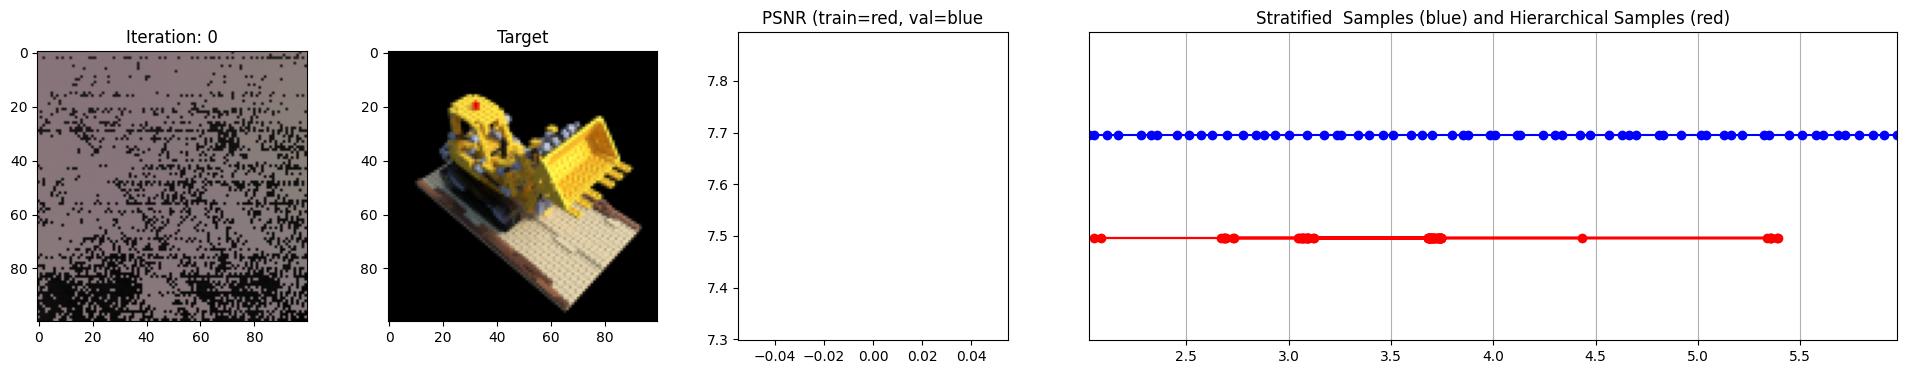

  5%|▍         | 999/20000 [01:29<29:12, 10.84it/s]

Loss: 0.01263484451919794


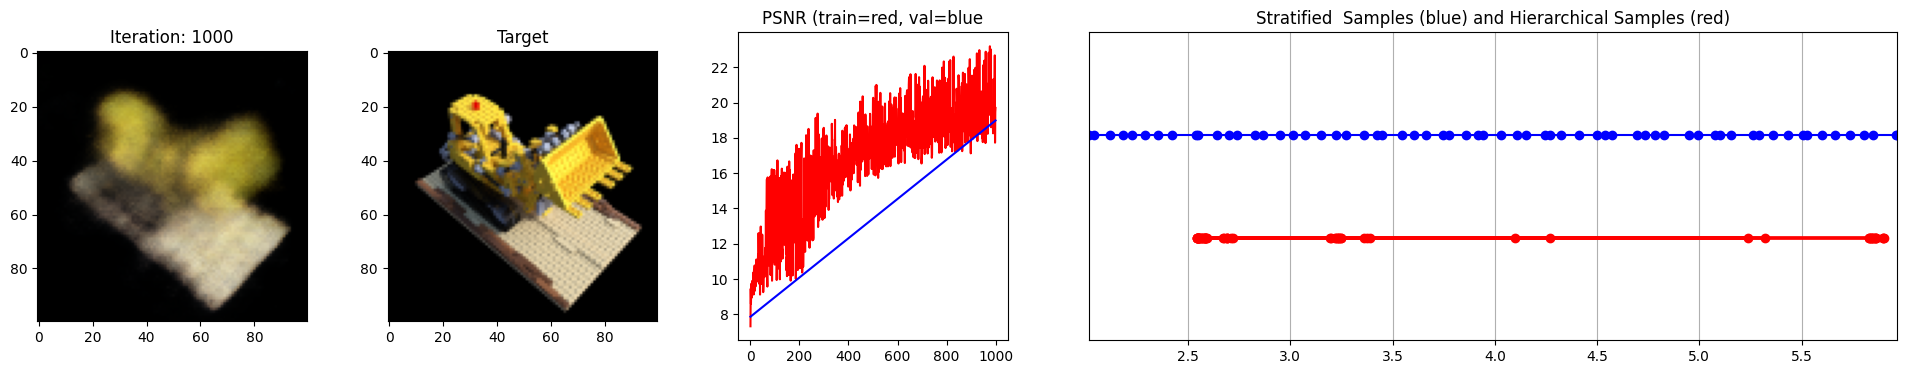

 10%|▉         | 1999/20000 [03:03<27:47, 10.79it/s]

Loss: 0.008965934626758099


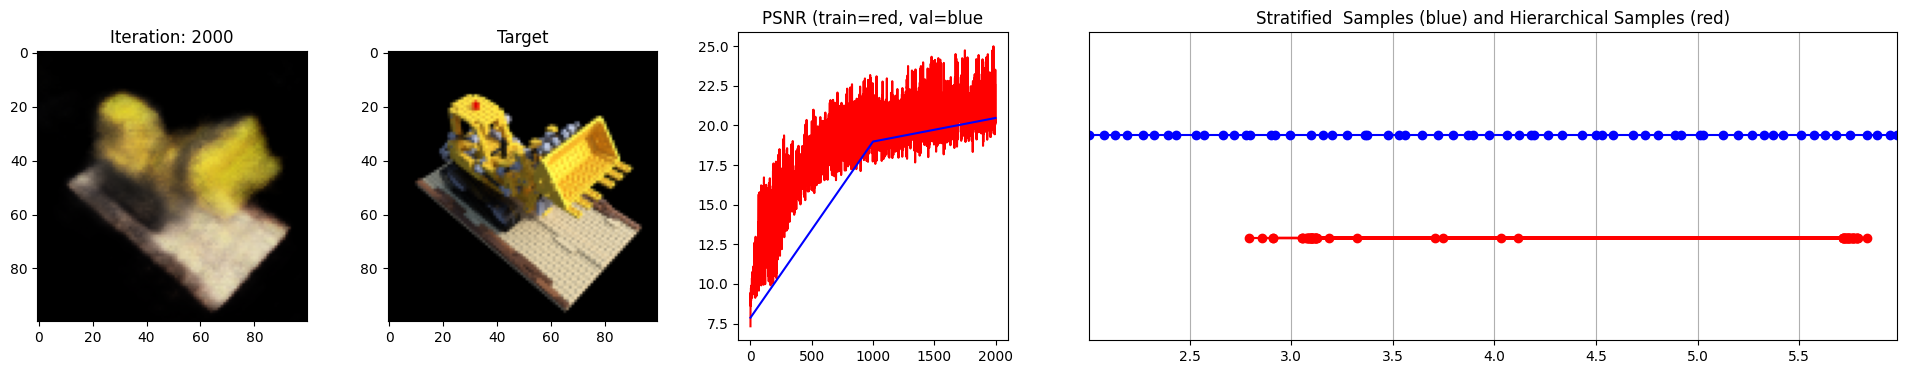

 15%|█▍        | 2999/20000 [04:36<26:13, 10.81it/s]

Loss: 0.007985751144587994


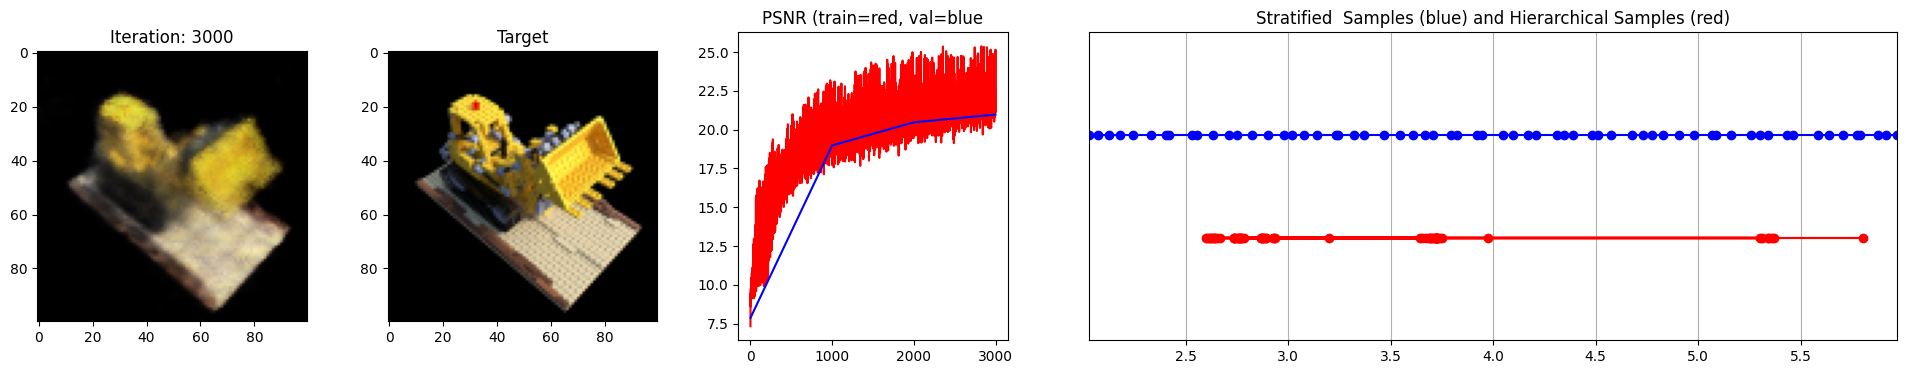

 20%|█▉        | 3999/20000 [06:09<24:43, 10.79it/s]

Loss: 0.006194131914526224


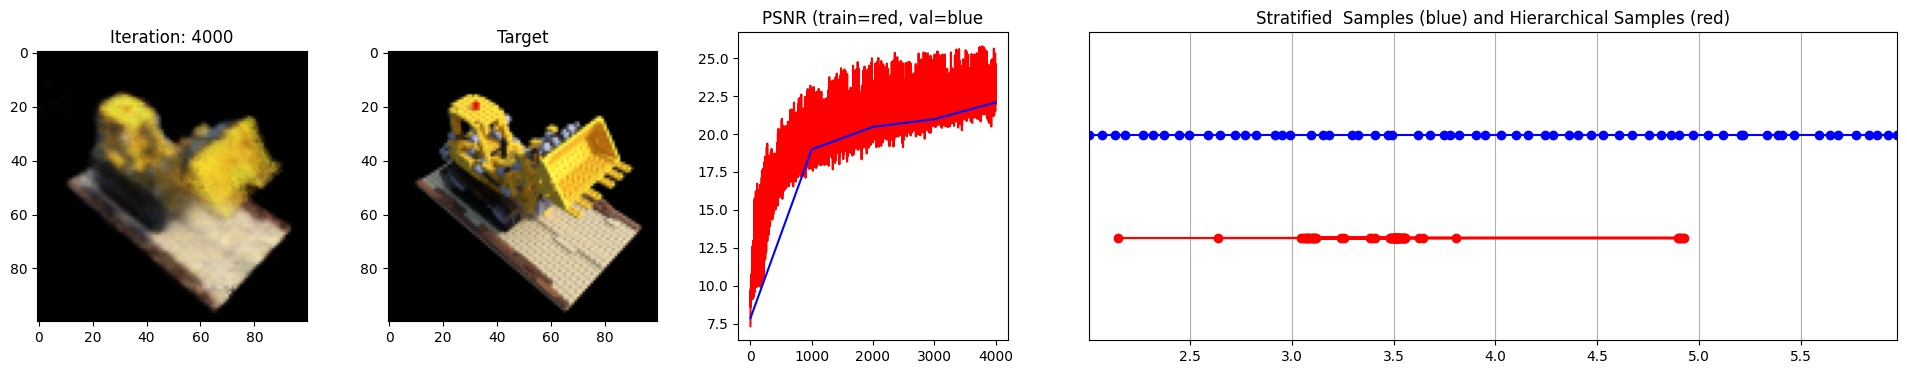

 25%|██▍       | 4999/20000 [07:43<23:09, 10.80it/s]

Loss: 0.005974633153527975


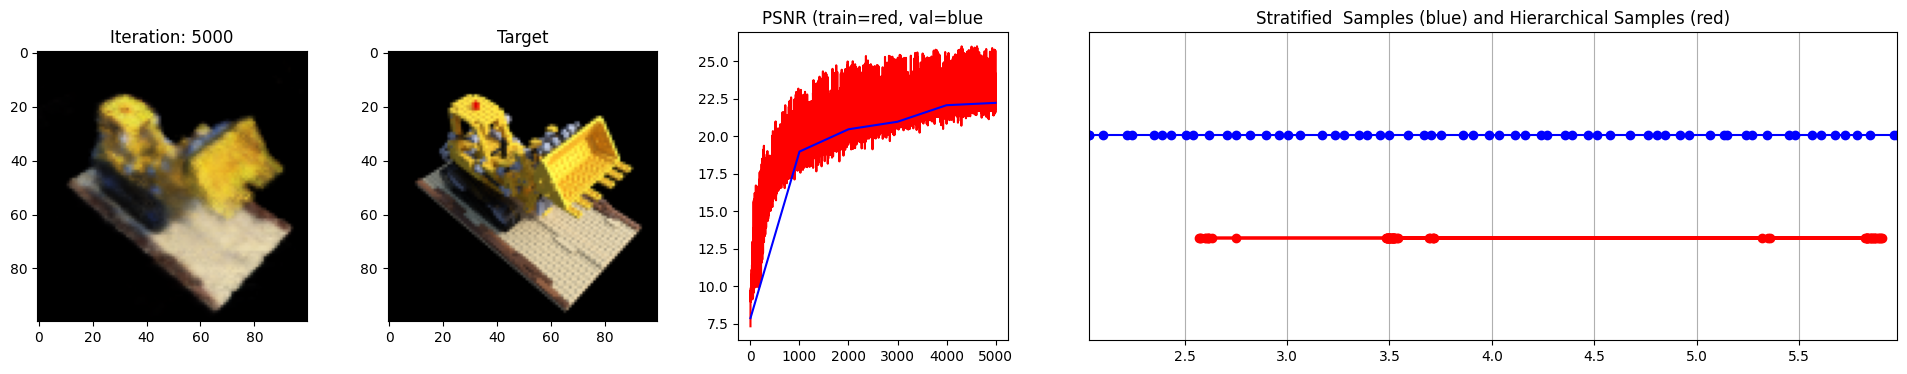

 30%|██▉       | 5999/20000 [09:16<21:37, 10.79it/s]

Loss: 0.005042021628469229


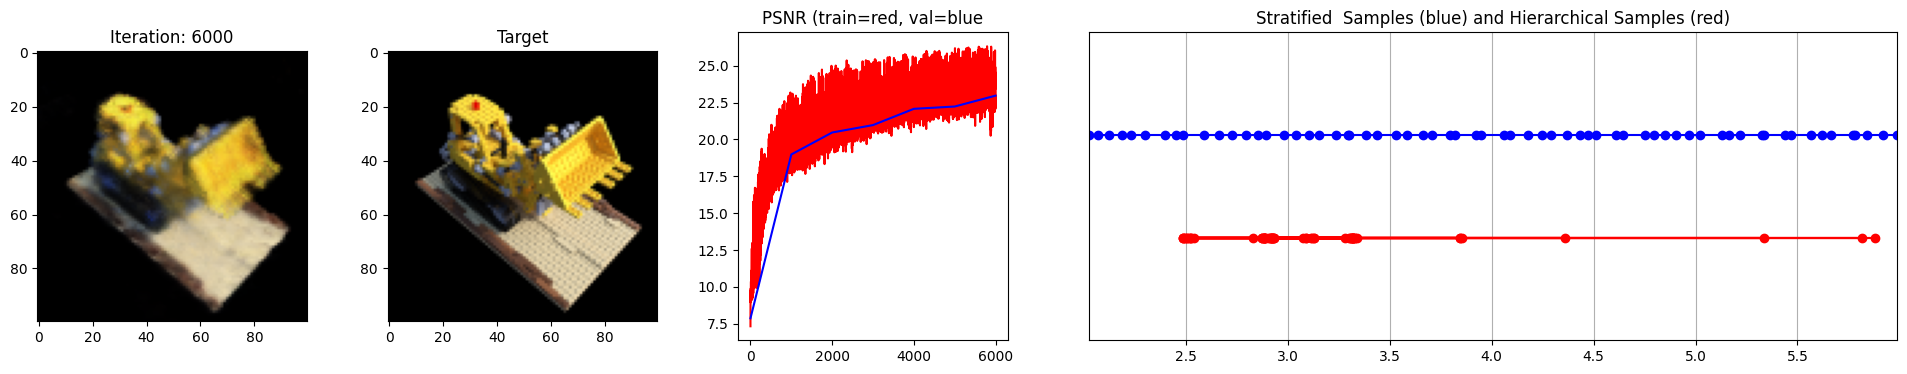

 35%|███▍      | 6999/20000 [10:49<19:57, 10.85it/s]

Loss: 0.0051740133203566074


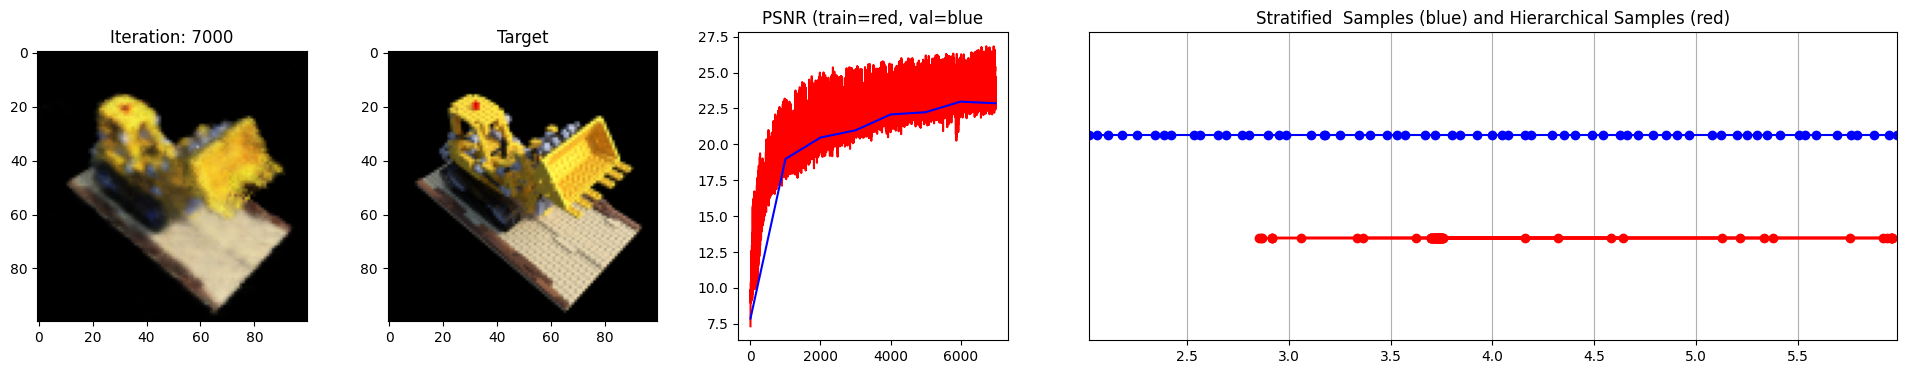

 36%|███▌      | 7154/20000 [11:04<19:53, 10.76it/s]


KeyboardInterrupt: 

In [ ]:
# Run training session(s)
for _ in range(n_restarts):
  model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper = init_models()
  success, train_psnrs, val_psnrs = train()
  if success and val_psnrs[-1] >= warmup_min_fitness:
    print('Training successful!')
    break

print('')
print(f'Done!')

In [ ]:
# Save your model
torch.save(model.state_dict(), 'nerf.pt')
torch.save(fine_model.state_dict(), 'nerf-fine.pt')

## Load a pre-trained model

In [ ]:
# Hyperparameters Setting
# Encoders
d_input = 3           # Number of input dimensions
n_freqs = 10          # Number of encoding functions for samples
log_space = True      # If set, frequencies scale in log space
use_viewdirs = True   # If set, use view direction as input
n_freqs_views = 4     # Number of encoding functions for views

# Stratified sampling
n_samples = 64         # Number of spatial samples per ray
perturb = True         # If set, applies noise to sample positions
inverse_depth = False  # If set, samples points linearly in inverse depth

# Model
d_filter = 128          # Dimensions of linear layer filters
n_layers = 2            # Number of layers in network bottleneck
skip = []               # Layers at which to apply input residual
use_fine_model = True   # If set, creates a fine model
d_filter_fine = 128     # Dimensions of linear layer filters of fine network
n_layers_fine = 6       # Number of layers in fine network bottleneck

# Hierarchical sampling
n_samples_hierarchical = 64   # Number of samples per ray
perturb_hierarchical = False  # If set, applies noise to sample positions

# Optimizer
lr = 5e-4  # Learning rate

# Training
n_iters = 10000 # training iters 1000 for test, 10000 for whole training
batch_size = 2**15          # Number of rays per gradient step (power of 2)
one_image_per_step = True   # One image per gradient step (disables batching)
chunksize = 2**15           # Modify as needed to fit in GPU memory
center_crop = True          # Crop the center of image (one_image_per_)
center_crop_iters = 50      # Stop cropping center after this many epochs
display_rate = 100          # Display test output every X epochs

# Early Stopping
warmup_iters = 100          # Number of iterations during warmup phase
warmup_min_fitness = 10   # Min val PSNR to continue training at warmup_iters
n_restarts = 10             # Number of times to restart if training stalls

# We bundle the kwargs for various functions to pass all at once.
kwargs_sample_stratified = {
    'n_samples': n_samples,
    'perturb': perturb,
    'inverse_depth': inverse_depth
}
kwargs_sample_hierarchical = {
    'perturb': perturb
}

In [ ]:
# Download the model
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1U5f8FvkSS5snvV1kKqykodsI-7wiS2zw' -O pre-trained-nerf-fine.pt
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Lafec944FbTMRyrnyibZILpOBif0zOTR' -O pre-trained-nerf.pt

--2024-10-24 15:52:24--  https://docs.google.com/uc?export=download&id=1U5f8FvkSS5snvV1kKqykodsI-7wiS2zw
Resolving docs.google.com (docs.google.com)... 142.250.101.102, 142.250.101.138, 142.250.101.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1U5f8FvkSS5snvV1kKqykodsI-7wiS2zw&export=download [following]
--2024-10-24 15:52:24--  https://drive.usercontent.google.com/download?id=1U5f8FvkSS5snvV1kKqykodsI-7wiS2zw&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209601 (205K) [application/octet-stream]
Saving to: ‘pre-trained-nerf-fine.pt’

pre-trained-nerf-fi 100%[===================>] 204.69K  --

In [ ]:
model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper = init_models()
model.load_state_dict(torch.load('pre-trained-nerf.pt'))
fine_model.load_state_dict(torch.load('pre-trained-nerf-fine.pt'))

<ipython-input-49-44e34fac52ae>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pre-trained-nerf.pt'))
<ipython-input-49-44e34fac52ae>:3: 

<All keys matched successfully>

Task1.5

In [ ]:
# Interactive Visualization
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets

# Transformations
trans_t = lambda t: torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, t],
    [0, 0, 0, 1],
], dtype=torch.float32)

# TODO: calculate rot_phi and rot_theta
# rot_phi =

# rot_theta =

# Pose calculation
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = torch.matmul(rot_phi(phi / 180. * np.pi), c2w)
    c2w = torch.matmul(rot_theta(theta / 180. * np.pi), c2w)
    c2w = torch.matmul(torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=torch.float32), c2w)
    return c2w

# Rendering function
def f(**kwargs):
    c2w = pose_spherical(**kwargs).to(device)
    height, width = testimg.shape[:2]
    rays_o, rays_d = get_rays(height, width, focal, c2w[:3,:4])
    rays_o = rays_o.reshape([-1, 3])
    rays_d = rays_d.reshape([-1, 3])

    outputs = nerf_forward(rays_o, rays_d, near=2., far=6., encoding_fn=encode, coarse_model=model,
                           kwargs_sample_stratified=kwargs_sample_stratified,
                           n_samples_hierarchical=n_samples_hierarchical,
                           kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                           fine_model=fine_model,
                           viewdirs_encoding_fn=encode_viewdirs,
                           chunksize=chunksize)

    rgb = outputs['rgb_map']

    img = np.clip(rgb.detach().cpu().numpy(), 0, 1)
    img = img.reshape([height, width, 3])

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()

# Slider function
sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

# Define slider parameters
names = [
    ['theta', [100., 0., 360.]],
    ['phi', [-30., -90., 0.]],
    ['radius', [4., 3., 5.]],
]

# Interactive plot
interactive_plot = interactive(f, **{s[0]: sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

## Render 360 Video

Task1.6

In [ ]:
from tqdm import tqdm_notebook as tqdm
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
# TODO: Implement here

  rgb = outputs['rgb_map']

  img = np.clip(rgb.detach().cpu().numpy(), 0, 1)
  img = img.reshape([height, width, 3])
  frames.append((255*img).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

<ipython-input-39-99c75b974da0>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
# Display the video
from IPython.display import HTML
from base64 import b64encode

with open('video.mp4', 'rb') as video_file:
    mp4 = video_file.read()

data_url = f"data:video/mp4;base64,{b64encode(mp4).decode()}"

HTML(f"""
<video width="400" controls autoplay loop>
    <source src="{data_url}" type="video/mp4">
</video>
""")

## Part2 Gaussian Splatting
This lab is built on https://github.com/Tasmay-Tibrewal/4DGaussians

## Download and setup the environment

In [ ]:
%cd /content
!git clone https://github.com/Tasmay-Tibrewal/4DGaussians
%cd 4DGaussians
!git submodule update --init --recursive

!pip install -r requirements.txt
!pip install -e submodules/depth-diff-gaussian-rasterization
!pip install -e submodules/simple-knn

# !pip install -q https://github.com/camenduru/diff-gaussian-rasterization/releases/download/v1.0/diff_gaussian_rasterization-0.0.0-cp310-cp310-linux_x86_64.1.whl
# !pip install -q https://github.com/camenduru/diff-gaussian-rasterization/releases/download/v1.0/simple_knn-0.0.0-cp310-cp310-linux_x86_64.1.whl

!sudo apt-get install libglm-dev
!pip3 install torch torchvision torchaudio

/content
Cloning into '4DGaussians'...
remote: Enumerating objects: 2689, done.
remote: Counting objects: 100% (359/359), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 2689 (delta 237), reused 208 (delta 148), pack-reused 2330 (from 1)
Receiving objects: 100% (2689/2689), 73.39 MiB | 19.61 MiB/s, done.
Resolving deltas: 100% (1270/1270), done.
/content/4DGaussians
Submodule 'submodules/depth-diff-gaussian-rasterization' (https://github.com/ingra14m/depth-diff-gaussian-rasterization) registered for path 'submodules/depth-diff-gaussian-rasterization'
Submodule 'submodules/simple-knn' (https://gitlab.inria.fr/bkerbl/simple-knn.git) registered for path 'submodules/simple-knn'
Cloning into '/content/4DGaussians/submodules/depth-diff-gaussian-rasterization'...
Cloning into '/content/4DGaussians/submodules/simple-knn'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (del

Obtaining file:///content/4DGaussians/submodules/depth-diff-gaussian-rasterization
  Preparing metadata (setup.py) ... done
  Running setup.py develop for diff_gaussian_rasterization
Obtaining file:///content/4DGaussians/submodules/simple-knn
  Preparing metadata (setup.py) ... done
  Running setup.py develop for simple_knn
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libglm-dev
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 188 kB of archives.
After this operation, 2,312 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglm-dev all 0.9.9.8+ds-2 [188 kB]
Fetched 188 kB in 2s (91.7 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: fal

## Data Preparation

In [ ]:
!mkdir /content/test
%cd /content/test
!wget https://huggingface.co/camenduru/4DGaussians/resolve/main/data/data.zip
!unzip data.zip

/content/test
--2024-10-24 15:32:19--  https://huggingface.co/camenduru/4DGaussians/resolve/main/data/data.zip
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.17, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/54/6f/546f5254879b01adbe4d90a6dfb3d38dbe03222785e85aa12bff42c456102d6a/4e901bd3463e874bed5dd6bbe3236a8b2348f9adb5ef20484f8ba8b6d96876ec?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27data.zip%3B+filename%3D%22data.zip%22%3B&response-content-type=application%2Fzip&Expires=1730043139&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMDA0MzEzOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy81NC82Zi81NDZmNTI1NDg3OWIwMWFkYmU0ZDkwYTZkZmIzZDM4ZGJlMDMyMjI3ODVlODVhYTEyYmZmNDJjNDU2MTAyZDZhLzRlOTAxYmQzNDYzZTg3NGJlZDVkZDZiYmUzMjM2YThiMjM0OGY5YWRiNWVmMjA0ODRmOGJhOGI2ZD

## Start the training

Task2.1

In [ ]:
%cd /content/4DGaussians
!python train.py -s /content/test/data/lego --port 6017 --expname "dnerf/lego" --configs arguments/dnerf/lego.py

/content/4DGaussians
2024-10-24 15:32:39.450145: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 15:32:39.467555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 15:32:39.488561: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 15:32:39.494876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 15:32:39.510482: I tensorflow/core/plat

Task2.2

In [ ]:
%cd /content/4DGaussians
!python render.py --model_path "output/dnerf/lego/"  --skip_train --configs arguments/dnerf/lego.py

/content/4DGaussians
Looking for config file in output/dnerf/lego/cfg_args
Config file found: output/dnerf/lego/cfg_args
Rendering  output/dnerf/lego/
feature_dim: 64 [24/10 15:45:03]
Loading trained model at iteration 20000 [24/10 15:45:03]
Found transforms_train.json file, assuming Blender data set! [24/10 15:45:03]
Reading Training Transforms [24/10 15:45:03]
Reading Test Transforms [24/10 15:45:05]
Generating Video Transforms [24/10 15:45:06]
hello!!!! [24/10 15:45:06]
Generating random point cloud (2000)... [24/10 15:45:06]
Loading Training Cameras [24/10 15:45:06]
Loading Test Cameras [24/10 15:45:06]
Loading Video Cameras [24/10 15:45:06]
Deformation Net Set aabb [1.29982098 1.29990645 1.29988719] [-1.29980838 -1.29981163 -1.29872349] [24/10 15:45:06]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 1.2998,  1.2999,  1.2999],
        [-1.2998, -1.2998, -1.2987]]) [24/10 15:45:06]
loading model from existsoutput/dnerf/lego/point_cloud/iteration_20000 [24/10 15:45:07]
point 

## Render 360 Video

Task2.3

In [ ]:
from IPython.display import HTML
from base64 import b64encode
def display_video(video_path):
  mp4 = open(video_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=1000 controls>
    <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

In [ ]:
save_dir = '/content/4DGaussians/output/dnerf/lego/video/ours_20000/video_rgb.mp4'

import os
import glob
# video_path = glob.glob(os.path.join(save_dir, "*-test.mp4"))[0]
display_video(save_dir)

## Part3 Comparison

# TODO:
- Compare the NeRF and Gaussian Splatting in terms of rendering quality (r.g., PSNR or SSIM), speed(e.g., frame per second), and memory usage (GPU memory or system memory).

- Evaluate the trade-offs in terms of photorealism vs. rendering speed based on the rendering results during experiments.